# pytorch模型部署

## 模型工作流

![hello](../images/p20.jpg)

## 数据流周期

![hello](../images/p21.jpg)

- 数百万已部署的数据仪表不断实时生成功耗数据。
- 收集数据并将其上传到云存储库。
- 在处理原始数据之前，先将其聚合到业务定义的变电站或区域级别。
- 进行特征工程，进而生成模型训练或评价所需的数据，特征集数据存储在数据库中。
- 调用再训练服务以继续训练预测模型，该模型的新版本将保存下来以便Web服务的评价可以再使用。
- 根据适应所需预测频率的计划评价Web服务。
- 预测的数据结果存储在最终用户可访问到的数据库中。
- 客户端检索预测并将其应用回网络中，根据所需用例再进行调用。

## 模型训练

In [33]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.fft as fft
import os
from tqdm import tqdm # 打印进度条
import math
from einops import rearrange, repeat, reduce
from scipy.fftpack import next_fast_len
import matplotlib.pyplot as plt
import functools
from functools import partial, wraps
from sympy import Poly, legendre, Symbol, chebyshevt
from scipy.special import eval_legendre
from scipy import signal
from torch.nn.modules.linear import Linear
from operator import mul
from typing import List
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset
import joblib
# 两种绘图接口
import plotly_express as px
import plotly.graph_objects as go

import warnings

warnings.filterwarnings("ignore")

In [2]:
# 读取数据
def loader(data_path=None, data=None, time_col=None, datetime=None, freq=None):
    """
    读取数据，并对输入数据时间列进行处理

    参数说明
    ----------
    data_path : {str}
        输入数据地址，如果为空，读取已有数据
    data : {DataFrame} of shape (n_samples, n_features)
        输入数据，如果需读取本地数据，将该值置空，否则传入已有数据
    time_col : {str}
        输入数据的时间列，如果没有时间列，生成时间戳范围，或者生成固定频率的时间戳数据
    datetime : {str} 
        时间列开始时间，如果time_col为空，需填入此项，格式为%Y-%m-%d %H:%M:%S
    freq : {int}
        时间序列频率，单位为秒

    返回值
    -------
    data : {DataFrame} of shape (n_samples, n_features)
        经过时间序列处理后的数据
    """
    # 读取原始数据
    if data_path == None:
        if data.empty is True:
            raise ValueError("data is not exist!")
        else:
            data = data
    else:
        data = pd.read_csv(data_path)
    
    # 时间列处理
    if time_col == None:
        # 筛选输入频率
        re_ = re.findall('[0-9]', freq)
        if len(re_) == 0:
            nums = 1
        else:
            nums = int(''.join(re_))
        # 生成时间间隔
        time_index = pd.date_range(start=pd.to_datetime(datetime),
                                   end=pd.to_datetime(datetime) +
                                   timedelta(seconds=(data.shape[0] - 1)*nums),
                                   freq=freq)
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit=freq),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col] # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [3]:
data_path = "../outputs/datasets/energy.csv"
ts_data = loader(data_path=data_path, data=None, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,2698.0,32.00
2012-01-01 01:00:00,2558.0,32.67
2012-01-01 02:00:00,2444.0,30.00
2012-01-01 03:00:00,2402.0,31.00
2012-01-01 04:00:00,2403.0,32.00
...,...,...
2014-12-31 19:00:00,4012.0,18.00
2014-12-31 20:00:00,3856.0,16.67
2014-12-31 21:00:00,3671.0,17.00
2014-12-31 22:00:00,3499.0,15.33


In [4]:
# 时间格式编码
def time_features_from_frequency_str(freq_str: str):
    """
    Returns a list of time features that will be appropriate for the given frequency string.
    Parameters
    ----------
    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.
    """

    class TimeFeature:
        def __init__(self):
            pass

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            pass

        def __repr__(self):
            return self.__class__.__name__ + "()"


    class SecondOfMinute(TimeFeature):
        """Minute of hour encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.second / 59.0 - 0.5


    class MinuteOfHour(TimeFeature):
        """Minute of hour encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.minute / 59.0 - 0.5


    class HourOfDay(TimeFeature):
        """Hour of day encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.hour / 23.0 - 0.5


    class DayOfWeek(TimeFeature):
        """Hour of day encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.dayofweek / 6.0 - 0.5


    class DayOfMonth(TimeFeature):
        """Day of month encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.day - 1) / 30.0 - 0.5


    class DayOfYear(TimeFeature):
        """Day of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.dayofyear - 1) / 365.0 - 0.5


    class MonthOfYear(TimeFeature):
        """Month of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.month - 1) / 11.0 - 0.5


    class WeekOfYear(TimeFeature):
        """Week of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.isocalendar().week - 1) / 52.0 - 0.5

    
    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}
    The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
    """
    raise RuntimeError(supported_freq_msg)
    
def time_features(dates, freq='h'):
    return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)])

In [5]:
# 包含时间维度的数据集划分
def divider(df, valid_date, test_date, x_feature_list, y_feature_list, freq, scaler_path):
    #归一化
    x_scaler = MinMaxScaler() # 保证数据同分布
    y_scaler = MinMaxScaler()
    x_scaler = x_scaler.fit(df.copy()[x_feature_list]) 
    y_scaler = y_scaler.fit(df.copy()[y_feature_list])

    # 设置保存归一化参数路径
    if not os.path.exists(scaler_path):
        os.makedirs(scaler_path)

    # 保存归一化参数
    joblib.dump(x_scaler, scaler_path + "/x_scaler.pkl")
    joblib.dump(y_scaler, scaler_path + "/y_scaler.pkl")

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train_stamp = time_features(pd.to_datetime(train.index), freq=freq)
    train_stamp = train_stamp.transpose(1, 0)
    train[x_feature_list] = x_scaler.transform(train)
    xtr = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid_stamp = time_features(pd.to_datetime(valid.index), freq=freq)
    valid_stamp = valid_stamp.transpose(1, 0)
    valid[x_feature_list] = x_scaler.transform(valid)
    xva = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test_stamp = time_features(pd.to_datetime(test.index), freq=freq)
    test_stamp = test_stamp.transpose(1, 0)
    test[x_feature_list] = x_scaler.transform(test)
    xte = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.transform(yte)
    yte = yte.values.astype('float32')
    
    # 数据合并，[训练集，测试集，时间戳]
    train = [xtr, ytr, train_stamp]
    valid = [xva, yva, valid_stamp]
    test = [xte, yte, test_stamp]
    
    return x_scaler, y_scaler, train, valid, test

In [6]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", 'temp'],
    "y_feature_list": ["load", 'temp'],
    "freq": 'h',
    "scaler_path": '../outputs/scalers/Transformer'
}

#函数传参
x_scaler, y_scaler, train_data, valid_data, test_data = divider(**params1)
print("x_train shape: {0} y_train shape: {1} stamp_train shape: {2}".format(train_data[0].shape, train_data[1].shape, train_data[2].shape))
print("x_valid shape: {0} y_valid shape: {1} stamp_valid shape: {2}".format(valid_data[0].shape, valid_data[1].shape, valid_data[2].shape))
print("x_test shape: {0} y_test shape: {1} stamp_test shape: {2}".format(test_data[0].shape, test_data[1].shape, test_data[2].shape))

x_train shape: (23376, 2) y_train shape: (23376, 2) stamp_train shape: (23376, 4)
x_valid shape: (1464, 2) y_valid shape: (1464, 2) stamp_valid shape: (1464, 4)
x_test shape: (1464, 2) y_test shape: (1464, 2) stamp_test shape: (1464, 4)


In [7]:
#利用前seq_len个数据，预测下pred_len个数据
def generator(data_list, seq_len, pred_len, label_len, batch_size):
    """
    @参数设置：
    data_list：特征，目标，时间戳
    seq_len：输入数据包含过去多少个时间步
    pred_len：目标应该在未来多少个时间步之后
    label_len：先验时间步
    """
    # 获取数据
    feature = data_list[0] # 特征
    target = data_list[1] # 目标
    stamp = data_list[2] # 时间戳
    
    # 循环生成数据
    X, y = [], []
    X_stamp, y_stamp = [], []
    seq_len = seq_len - 1 # 包含当前时间点
    for i in range(seq_len, len(feature) - pred_len):
        # 数据维度
        feat = feature[i - seq_len:i + 1]
        tar = target[i + 1:i + 1 + pred_len]
        X.append(feat)
        y.append(tar)
        
        # 时间维度
        xs = stamp[i - seq_len:i + 1]
        ys = stamp[i + 1 - label_len:i + 1 + pred_len]
        X_stamp.append(xs)
        y_stamp.append(ys)
        
    # 转为张量，数据维度
    X = torch.as_tensor(X).float()
    y = torch.as_tensor(y).float()
    
    # 转为张量，时间维度
    X_stamp = torch.as_tensor(X_stamp).float()
    y_stamp = torch.as_tensor(y_stamp).float()
    
    # 创建dataloader，[特征，目标，特征时间编码，目标时间编码]
    data_loader = DataLoader(TensorDataset(X, y, X_stamp, y_stamp), shuffle=True, batch_size=batch_size)
    
    return X, y, X_stamp, y_stamp, data_loader

In [8]:
# 构造参数字典
params2 = {
    "seq_len": 6,
    "pred_len": 3,
    "label_len": 3,
    "batch_size": 32,
}
X_train, y_train, X_train_stamp, y_train_stamp, train_loader = generator(train_data, **params2)
X_valid, y_valid, X_valid_stamp, y_valid_stamp, valid_loader = generator(valid_data, **params2)
X_test, y_test, X_test_stamp, y_test_stamp, test_loader = generator(test_data, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23368, 6, 2]),y_size: torch.Size([23368, 3, 2]),loader_len: 731
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 2]),loader_len: 46
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 2]),loader_len: 46


In [29]:
def train(task_args, train_args, model_args):
    # 参数配置
    columns = task_args['columns'] # 模型全部特征
    target = task_args['target'] # 模型预测特征
    features = task_args['features'] # 模型预测模式
    model_name = train_args['model_name'] # 模型名称
    train_loader = train_args['train_loader'] # 训练集
    valid_loader = train_args['valid_loader'] # 验证集
    n_epochs = train_args['n_epochs'] # 训练次数
    learning_rate = train_args['learning_rate'] # 学习率
    loss = train_args['loss'] # 损失函数
    patience = train_args['patience'] # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj'] # 学习率函数
    model_path = train_args['model_path'] # 模型保存路径
    verbose = train_args['verbose'] # 打印训练过程
    plots = train_args['plots'] # 绘制损失图
    device = train_args['device'] # 训练设备，可选'cuda'和'cpu'
    pred_len = model_args['pred_len'] # 预测长度
    label_len = model_args['label_len']
    
    #检查是否可用GPU
    device = torch.device(device)
    
    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = loss
    
    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate /2 * (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    
    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    
    # 训练任务
    def forecasting_task(columns, target, features):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            if target in columns:
                f_dim = col_dict[target]
            else:
                f_dim = 0
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0
        return f_dim
    f_dim = forecasting_task(columns, target, features)
    
    # 设置保存模型路径
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    # 模型训练和验证
    train_losses, val_losses = [], []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for batch_x, batch_y, batch_x_mark, batch_y_mark in train_loader:
            #将数据移至 GPU
            batch_x = batch_x.to(device) # 会用到实际数据
            batch_y = batch_y.to(device) # 只用来获取维度，不会用到实际数据，防止泄露信息
            batch_x_mark = batch_x_mark.to(device)
            batch_y_mark = batch_y_mark.to(device)
            # 清空梯度
            optimizer.zero_grad()
            # decoder输入 
            dec_inp = torch.zeros_like(batch_y[:, -pred_len:, :]).float()
            # attn_mask
            B = batch_x.shape[0]
            L = batch_x.shape[1]
            mask_shape = [B, 1, L, L]
            attn_mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)
            if features == 'MS':
                dec_inp = torch.cat([batch_x[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float().to(device)
                outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark, attn_mask)
                outputs = outputs[:, :, f_dim: f_dim+1] 
            else:
                dec_inp = torch.cat([batch_x[:, -label_len:, f_dim:], dec_inp], dim=1).float().to(device)
                outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark, attn_mask)
                outputs = outputs[:, :, f_dim:]
            train_loss = criterion(outputs, batch_y)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for batch_x, batch_y, batch_x_mark, batch_y_mark in valid_loader:
                #将数据移至 GPU
                batch_x = batch_x.to(device) # 会用到实际数据
                batch_y = batch_y.to(device) # 只用来获取维度，不会用到实际数据，防止泄露信息
                batch_x_mark = batch_x_mark.to(device)
                batch_y_mark = batch_y_mark.to(device)
                # decoder输入
                dec_inp = torch.zeros_like(batch_y[:, -pred_len:, :]).float()
                # attn_mask
                B = batch_x.shape[0]
                L = batch_x.shape[1]
                mask_shape = [B, 1, L, L]
                attn_mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)
                if features == 'MS':
                    dec_inp = torch.cat([batch_x[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float().to(device)
                    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark, attn_mask)
                    outputs = outputs[:, :, f_dim: f_dim+1] 
                else:
                    dec_inp = torch.cat([batch_x[:, -label_len:, f_dim:], dec_inp], dim=1).float().to(device)
                    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark, attn_mask)
                    outputs = outputs[:, :, f_dim:]
                val_loss = criterion(outputs, batch_y)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
            
        # 设置早停
        early_stopping(avg_val_loss, model, model_path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break
            
        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj, learning_rate, n_epochs)

    #绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.plot(val_losses, linestyle='-',color = '#11b3b6')
        plt.plot(train_losses, linestyle='-',color = '#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)
            
    return model

In [30]:
# 读取本地模型
import sys
path = '../outputs/models'
sys.path.insert(0, path)

from Transformer import Transformer

  5%|████▏                                                                              | 1/20 [01:21<25:49, 81.57s/it]

Epoch [1/20], Training Loss: 0.0189, Validation Loss: 0.0031
Validation loss decreased (inf --> 0.003077).  Saving model ...
Updating learning rate to 0.0009938441702975688


 10%|████████▎                                                                          | 2/20 [02:43<24:37, 82.07s/it]

Epoch [2/20], Training Loss: 0.0050, Validation Loss: 0.0059
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0009755282581475768


 15%|████████████▍                                                                      | 3/20 [04:08<23:33, 83.13s/it]

Epoch [3/20], Training Loss: 0.0038, Validation Loss: 0.0020
Validation loss decreased (0.003077 --> 0.001964).  Saving model ...
Updating learning rate to 0.0009455032620941839


 20%|████████████████▌                                                                  | 4/20 [05:41<23:12, 87.04s/it]

Epoch [4/20], Training Loss: 0.0032, Validation Loss: 0.0019
Validation loss decreased (0.001964 --> 0.001933).  Saving model ...
Updating learning rate to 0.0009045084971874737


 25%|████████████████████▊                                                              | 5/20 [07:13<22:15, 89.01s/it]

Epoch [5/20], Training Loss: 0.0029, Validation Loss: 0.0020
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0008535533905932737


 30%|████████████████████████▉                                                          | 6/20 [08:46<21:00, 90.06s/it]

Epoch [6/20], Training Loss: 0.0026, Validation Loss: 0.0015
Validation loss decreased (0.001933 --> 0.001537).  Saving model ...
Updating learning rate to 0.0007938926261462366


 35%|█████████████████████████████                                                      | 7/20 [10:18<19:41, 90.90s/it]

Epoch [7/20], Training Loss: 0.0023, Validation Loss: 0.0019
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0007269952498697733


 40%|█████████████████████████████████▏                                                 | 8/20 [11:49<18:11, 90.92s/it]

Epoch [8/20], Training Loss: 0.0022, Validation Loss: 0.0012
Validation loss decreased (0.001537 --> 0.001168).  Saving model ...
Updating learning rate to 0.0006545084971874737


 45%|█████████████████████████████████████▎                                             | 9/20 [13:22<16:47, 91.59s/it]

Epoch [9/20], Training Loss: 0.0019, Validation Loss: 0.0024
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0005782172325201155


 50%|█████████████████████████████████████████                                         | 10/20 [14:54<15:17, 91.72s/it]

Epoch [10/20], Training Loss: 0.0018, Validation Loss: 0.0011
Validation loss decreased (0.001168 --> 0.001133).  Saving model ...
Updating learning rate to 0.0005


 55%|█████████████████████████████████████████████                                     | 11/20 [16:27<13:47, 91.95s/it]

Epoch [11/20], Training Loss: 0.0017, Validation Loss: 0.0013
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0004217827674798845


 60%|█████████████████████████████████████████████████▏                                | 12/20 [17:58<12:13, 91.69s/it]

Epoch [12/20], Training Loss: 0.0015, Validation Loss: 0.0020
EarlyStopping counter: 2 out of 3
Updating learning rate to 0.00034549150281252633


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [19:29<10:40, 91.55s/it]

Epoch [13/20], Training Loss: 0.0014, Validation Loss: 0.0009
Validation loss decreased (0.001133 --> 0.000932).  Saving model ...
Updating learning rate to 0.00027300475013022663


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [21:02<09:11, 91.86s/it]

Epoch [14/20], Training Loss: 0.0014, Validation Loss: 0.0010
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.00020610737385376348


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [22:34<07:39, 91.96s/it]

Epoch [15/20], Training Loss: 0.0013, Validation Loss: 0.0008
Validation loss decreased (0.000932 --> 0.000755).  Saving model ...
Updating learning rate to 0.00014644660940672628


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [24:06<06:08, 92.01s/it]

Epoch [16/20], Training Loss: 0.0012, Validation Loss: 0.0008
EarlyStopping counter: 1 out of 3
Updating learning rate to 9.549150281252633e-05


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [25:40<04:37, 92.62s/it]

Epoch [17/20], Training Loss: 0.0012, Validation Loss: 0.0008
Validation loss decreased (0.000755 --> 0.000753).  Saving model ...
Updating learning rate to 5.449673790581611e-05


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [27:14<03:05, 92.96s/it]

Epoch [18/20], Training Loss: 0.0012, Validation Loss: 0.0008
EarlyStopping counter: 1 out of 3
Updating learning rate to 2.4471741852423235e-05


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [28:47<01:32, 92.94s/it]

Epoch [19/20], Training Loss: 0.0012, Validation Loss: 0.0008
EarlyStopping counter: 2 out of 3
Updating learning rate to 6.15582970243117e-06


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [30:23<01:35, 95.95s/it]

Epoch [20/20], Training Loss: 0.0011, Validation Loss: 0.0008
EarlyStopping counter: 3 out of 3
Early stopping!


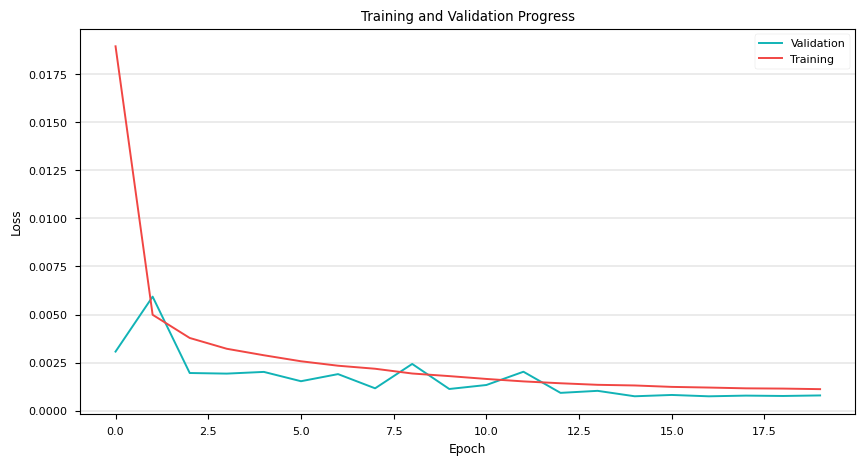

In [31]:
# 构造参数字典
params3 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['load', 'temp'],
        "features": 'M'
    },
    "train_args": {
        "model_name": Transformer,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 20,
        "learning_rate": 0.001,
        "loss": nn.MSELoss(),
        "patience": 3,
        "device": 'cpu',
        "lradj": 'cosine',
        "model_path": "../outputs/best_models/Transformer",
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'pred_len': 3, 
        "label_len": 3,
        'output_attention': True,
        'embed': 'fixed',
        'freq': 'h',
        'd_model': 128,
        'enc_in': 2,
        'dec_in':2,
        'dropout': 0.1,
        'factor': 3,
        'n_heads': 8,
        'd_ff': 128,
        'e_layers': 1,
        'd_layers': 1,
        'c_out': 2
    },
}
model = train(**params3)

## 模型保存

在许多深度学习框架中，可以直接保存整个模型，包括模型的架构、权重和训练状态。

### 保存模型权重

只保存模型权重时，如果是在GPU上训练的模型，可以在CPU上跑。

In [32]:
weight_path = '../outputs/models/weights/transformer_weights.pth'
torch.save(model.state_dict(), weight_path)

### 保存整个模型

如果保存整个模型，会根据模型训练方式（CPU训练或者GPU训练），自动选择加载设备。即GPU上跑GPU模型，CPU上跑CPU模型。

In [33]:
# 必须将模型单独写成py文件才能保存
model_path = '../outputs/models/best_models/transformer.pth'
torch.save(model, model_path)

## 模型加载

### 加载整个模型

如果之前使用了torch.save(model, model_path)，那说明保存的是整个模型对象而不是脚本化的模型。在这种情况下，加载模型时使用 torch.load 即可。

In [34]:
model_path = '../outputs/models/best_models/transformer.pth'
transformer_model = torch.load(model_path)

### 加载模型权重

如果之前使用了torch.save(model.state_dict(), model_path)，在加载时需要加载模型的权重，并在模型实例上应用这些权重。

In [35]:
weight_path = '../outputs/models/weights/transformer_weights.pth'
model_args = {
        'pred_len': 3, 
        "label_len": 3,
        'output_attention': True,
        'embed': 'fixed',
        'freq': 'h',
        'd_model': 128,
        'enc_in': 2,
        'dec_in':2,
        'dropout': 0.1,
        'factor': 3,
        'n_heads': 8,
        'd_ff': 128,
        'e_layers': 1,
        'd_layers': 1,
        'c_out': 2
    }
transformer_model = Transformer(**model_args)
state_dict = torch.load(weight_path)
transformer_model.load_state_dict(state_dict)

<All keys matched successfully>

### CPU和GPU模型转换

如果模型是在GPU上训练，保存模型后，想在CPU上推理，加载模型时只需使用如下代码：  
`state_dict = torch.load(path, map_location='cpu') `  
`model.load_state_dict()`

如果模型已在CPU加载，想部署到GPU，可以使用如下代码：  
`device=torch.device('cuda')`  
`model.to(device)`

## 模型预测

In [94]:
def predict(task_args, predict_args, model_args):
    # 参数配置
    columns = task_args['columns']
    target = task_args['target'] 
    time_col = predict_args['time_col']
    features = task_args['features'] 
    freq = predict_args['freq']
    model_name = predict_args['model_name'] 
    x_true = predict_args['x_true'] 
    scaler_path = predict_args['scaler_path']
    model_path = predict_args['model_path'] 
    device = predict_args['device'] # 预测设备，可选'cuda'和'cpu'
    pred_len = model_args['pred_len'] 
    label_len = model_args['label_len']

    #检查是否可用GPU
    device = torch.device(device)

    # 读取归一化参数
    x_scaler = joblib.load(scaler_path + "/x_scaler.pkl")
    y_scaler = joblib.load(scaler_path + "/y_scaler.pkl")

    # 加载模型
    model = model_name(**model_args)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)

    # 生成固定长度的时间范围
    x_true = loader(data_path=None, data=x_true, time_col=time_col) # 原始数据
    x_true = x_true[columns]
    timedelta = x_true.index[-1] - x_true.index[-2] # 时间差
    if label_len != 0:
        y_stamp = pd.date_range(start=x_true.index[-label_len], 
                                end=x_true.index[-label_len]+timedelta*(label_len+pred_len-1), 
                                freq=freq)
    else:
        y_stamp = pd.date_range(start=x_true.index[-1]+timedelta*(label_len+1), 
                                end=x_true.index[-1]+timedelta*(label_len+pred_len), 
                                freq=freq) 
    x_stamp = time_features(pd.to_datetime(x_true.index), freq=freq) # x时间戳数据
    x_stamp = x_stamp.transpose(1, 0)
    y_time = y_stamp
    y_stamp = time_features(y_stamp, freq=freq) # y时间戳数据
    y_stamp = y_stamp.transpose(1, 0)
    

    # 转换类型
    x_true[columns] = x_scaler.transform(x_true) # 归一化
    x_true = x_true.values.astype('float32')
    x_true = torch.as_tensor(x_true).unsqueeze(0).float() # 转为张量
    x_stamp = torch.as_tensor(x_stamp).unsqueeze(0).float()
    y_stamp = torch.as_tensor(y_stamp).unsqueeze(0).float()
    
    # 任务分类
    def forecasting_task(columns, target, features):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            if target in columns:
                f_dim = col_dict[target]
            else:
                f_dim = 0
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0
        return f_dim
    f_dim = forecasting_task(columns, target, features)

    # 关闭自动求导功能
    model.eval() # 切换为推理模式
    with torch.no_grad():
        x_true = x_true.to(device)
        x_stamp = x_stamp.to(device)
        y_stamp = y_stamp.to(device)
        # decoder输入
        B, _, _ = x_true.shape
        dec_inp = torch.zeros((B, pred_len, len(target))).float().to(device)
        # attn_mask
        B = x_true.shape[0]
        L = x_true.shape[1]
        mask_shape = [B, 1, L, L]
        attn_mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)
        if features == 'MS':
            dec_inp = torch.cat([x_true[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float()
            y_pred = model(x_true, x_stamp, dec_inp, y_stamp, attn_mask)
            y_pred = y_pred.cpu().detach().numpy() 
            y_pred = y_scaler.inverse_transform(y_pred[-1, :, :]) # 反归一化
            y_pred = y_pred[:, f_dim: f_dim+1]
        else:
            dec_inp = torch.cat([x_true[:, -label_len:, f_dim:], dec_inp], dim=1).float()
            y_pred = model(x_true, x_stamp, dec_inp, y_stamp, attn_mask)
            y_pred = y_pred.cpu().detach().numpy() 
            print(y_pred.shape)
            y_pred = y_scaler.inverse_transform(y_pred[-1, :, :]) # 反归一化
            print(y_pred.shape)
            y_pred = y_pred[:, f_dim:]

    # 输出为dataframe
    y_pred = pd.DataFrame(data=y_pred, index=y_time[-pred_len:], columns=target)
    
    return y_pred

In [95]:
# 构造参数字典
params6 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['load', 'temp'],
        "features": 'M',
    },
    "predict_args": {
        "time_col": 'time',
        "freq": 'h',
        "model_name": Transformer,
        "model_path": "../outputs/models/weights/transformer_weights.pth",
        "x_true": pd.read_csv(data_path).iloc[:6, :],
        "scaler_path": '../outputs/scalers/Transformer',
        "device": 'cpu'
    },
    "model_args": {
        'pred_len': 3, 
        "label_len": 3,
        'output_attention': True,
        'embed': 'fixed',
        'freq': 'h',
        'd_model': 128,
        'enc_in': 2,
        'dec_in':2,
        'dropout': 0.1,
        'factor': 3,
        'n_heads': 8,
        'd_ff': 128,
        'e_layers': 1,
        'd_layers': 1,
        'c_out': 2
    },
}
y_pred = predict(**params6)

(1, 3, 2)
(3, 2)


In [40]:
y_pred

,load,temp
2012-01-01 06:00:00,2641.291748,30.517662
2012-01-01 07:00:00,2955.476807,30.698469
2012-01-01 08:00:00,3226.948730,31.756979


# onnx模型部署

开放神经网络交换ONNX（Open Neural Network Exchange）是一套表示深度神经网络模型的开放格式，由微软和Facebook于2017推出，然后迅速得到了各大厂商和框架的支持。通过短短几年的发展，已经成为表示深度学习模型的实际标准，并且通过ONNX-ML，可以支持传统非神经网络机器学习模型，大有一统整个AI模型交换标准。ONNX定义了一组与环境和平台无关的标准格式，为AI模型的互操作性提供了基础，使AI模型可以在不同框架和环境下交互使用。硬件和软件厂商可以基于ONNX标准优化模型性能，让所有兼容ONNX标准的框架受益，简单来说，ONNX就是模型转换的中间人。

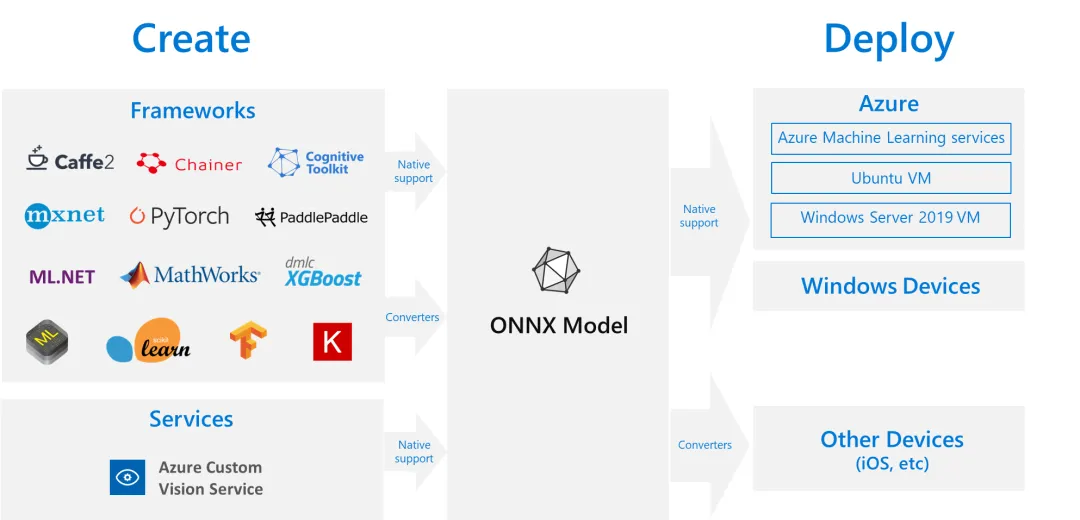

无论你使用什么样的训练框架来训练模型（比如TensorFlow/Pytorch/OneFlow/Paddle），你都可以在训练后将这些框架的模型统一转为ONNX存储。ONNX文件不仅存储了神经网络模型的权重，还存储了模型的结构信息、网络中各层的输入输出等一些信息。目前，ONNX主要关注在模型预测方面（inferring），将转换后的ONNX模型，转换成我们需要使用不同框架部署的类型，可以很容易的部署在兼容ONNX的运行环境中。

目前onnx不支持triu功能，需要在模型外部计算，将值传入模型内。在onnxruntime推理时，输入需要是numpy格式，需要将tensor转换为numpy。

## 模型保存

In [41]:
weight_path = '../outputs/models/weights/transformer_weights.pth'
model_args = {
        'pred_len': 3, 
        "label_len": 3,
        'output_attention': True,
        'embed': 'fixed',
        'freq': 'h',
        'd_model': 128,
        'enc_in': 2,
        'dec_in':2,
        'dropout': 0.1,
        'factor': 3,
        'n_heads': 8,
        'd_ff': 128,
        'e_layers': 1,
        'd_layers': 1,
        'c_out': 2
    }
transformer_model = Transformer(**model_args)
state_dict = torch.load(weight_path)
transformer_model.load_state_dict(state_dict)

<All keys matched successfully>

In [42]:
# 生成随机张量
x_true = torch.tensor([[[0.2216, 0.4203], [0.1784, 0.4264], [0.1433, 0.4019],
                        [0.1304, 0.4111], [0.1307, 0.4203], [0.1461, 0.4141]]])

x_stamp = torch.tensor([[[-0.5000, 0.5000, -0.5000, -0.5000],
                         [-0.4565, 0.5000, -0.5000, -0.5000],
                         [-0.4130, 0.5000, -0.5000, -0.5000],
                         [-0.3696, 0.5000, -0.5000, -0.5000],
                         [-0.3261, 0.5000, -0.5000, -0.5000],
                         [-0.2826, 0.5000, -0.5000, -0.5000]]])

dec_inp = torch.tensor([[[0.1304, 0.4111], [0.1307, 0.4203], [0.1461, 0.4141],
                         [0.0000, 0.0000], [0.0000, 0.0000], [0.0000, 0.0000]]])

y_stamp = torch.tensor([[[-0.3696, 0.5000, -0.5000, -0.5000],
                         [-0.3261, 0.5000, -0.5000, -0.5000],
                         [-0.2826, 0.5000, -0.5000, -0.5000],
                         [-0.2391, 0.5000, -0.5000, -0.5000],
                         [-0.1957, 0.5000, -0.5000, -0.5000],
                         [-0.1522, 0.5000, -0.5000, -0.5000]]])
B = 1
L = 6
mask_shape = [B, 1, L, L]
attn_mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1)

In [43]:
# 切换为推理模式
transformer_model.eval()

Transformer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(2, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TemporalEmbedding(
      (hour_embed): FixedEmbedding(
        (emb): Embedding(24, 128)
      )
      (weekday_embed): FixedEmbedding(
        (emb): Embedding(7, 128)
      )
      (day_embed): FixedEmbedding(
        (emb): Embedding(32, 128)
      )
      (month_embed): FixedEmbedding(
        (emb): Embedding(13, 128)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0): EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): FullAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (query_projection): Linear(in_features=128, out_features=128, bias=True)
          (key_projection

In [44]:
# 设置ONNX模型保存路径
export_onnx_path = "../outputs/models/transformer.onnx"

In [45]:
torch.onnx.export(
    model=transformer_model,
    args=(x_true, x_stamp, dec_inp, y_stamp, attn_mask),
    f=export_onnx_path,
    verbose=True,
    opset_version=17,
    do_constant_folding=True,  # 是否执行常量折叠优化
    input_names=['x_true', 'x_stamp', 'dec_inp', 'y_stamp', 'attn_mask'],  # 输入名
    output_names=['output'],  # 输出名
    dynamic_axes={ # 指定模型的动态轴
        'x_true': {
            0: 'batch_size'
        },  
        'x_stamp': {
            0: 'batch_size'
        },
        'dec_inp': {
            0: 'batch_size'
        },
        'y_stamp': {
            0: 'batch_size'
        },
        'attn_mask': {
            0: 'batch_size'
        },
        'output': {
            0: 'batch_size'
        }
    })

================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



## 模型加载

In [46]:
# 加载和检查导出的ONNX模型
import onnx
onnx_model = onnx.load(export_onnx_path)

# 检查模型，发现问题时会打印相关信息
onnx.checker.check_model(onnx_model)

## 模型可视化

netron官网地址为：[netron](https://netron.app/)  
通过netron可以直观的可视化onnx模型结构，利于理解与调整。

## 模型预测

### 功能测试

In [49]:
import onnxruntime as ort

# 将模型序列化为字符串
onnx_model_serialized = onnx_model.SerializeToString()

# 使用指定的提供者创建推理会话
sess_options = ort.SessionOptions()
providers = ['CPUExecutionProvider']
sess = ort.InferenceSession(onnx_model_serialized, sess_options, providers=providers)

In [52]:
input_name1 = sess.get_inputs()[0].name
input_name2 = sess.get_inputs()[1].name
input_name3 = sess.get_inputs()[2].name
input_name4 = sess.get_inputs()[3].name
input_name5 = sess.get_inputs()[4].name
output_name = sess.get_outputs()[0].name

In [59]:
x_true = torch.tensor([[[0.2216, 0.4203], [0.1784, 0.4264], [0.1433, 0.4019],
                        [0.1304, 0.4111], [0.1307, 0.4203], [0.1461, 0.4141]]])

x_stamp = torch.tensor([[[-0.5000, 0.5000, -0.5000, -0.5000],
                         [-0.4565, 0.5000, -0.5000, -0.5000],
                         [-0.4130, 0.5000, -0.5000, -0.5000],
                         [-0.3696, 0.5000, -0.5000, -0.5000],
                         [-0.3261, 0.5000, -0.5000, -0.5000],
                         [-0.2826, 0.5000, -0.5000, -0.5000]]])

dec_inp = torch.tensor([[[0.1304, 0.4111], [0.1307, 0.4203], [0.1461, 0.4141],
                         [0.0000, 0.0000], [0.0000, 0.0000], [0.0000, 0.0000]]])

y_stamp = torch.tensor([[[-0.3696, 0.5000, -0.5000, -0.5000],
                         [-0.3261, 0.5000, -0.5000, -0.5000],
                         [-0.2826, 0.5000, -0.5000, -0.5000],
                         [-0.2391, 0.5000, -0.5000, -0.5000],
                         [-0.1957, 0.5000, -0.5000, -0.5000],
                         [-0.1522, 0.5000, -0.5000, -0.5000]]])
B = 1
L = 6
mask_shape = [B, 1, L, L]
attn_mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1)

In [60]:
# 将 PyTorch 张量转换为 numpy 数组
x_true_np = x_true.cpu().numpy()
x_stamp_np = x_stamp.cpu().numpy()
dec_inp_np = dec_inp.cpu().numpy()
y_stamp_np = y_stamp.cpu().numpy()
attn_mask_np = attn_mask.cpu().numpy()

In [88]:
# 使用转换后的 numpy 数组作为输入
output = sess.run(
    [output_name], {
        input_name1: x_true_np,
        input_name2: x_stamp_np,
        input_name3: dec_inp_np,
        input_name4: y_stamp_np,
        input_name5: attn_mask_np
    })

In [93]:
output[0]

array([[[0.20412195, 0.40663266],
        [0.30094713, 0.40829346],
        [0.38461053, 0.4180346 ]]], dtype=float32)

### 完整实现

使用onnxruntime进行推理，极大的减少空间的占用。onnx大小34.0MB，onnxruntime大小21.0MB，torch787MB。

In [27]:
import onnx
import onnxruntime as ort
import pandas as pd
import numpy as np
import joblib
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset

In [28]:
# 读取数据
def loader(data_path=None, data=None, time_col=None, datetime=None, freq=None):
    """
    读取数据，并对输入数据时间列进行处理

    参数说明
    ----------
    data_path : {str}
        输入数据地址，如果为空，读取已有数据
    data : {DataFrame} of shape (n_samples, n_features)
        输入数据，如果需读取本地数据，将该值置空，否则传入已有数据
    time_col : {str}
        输入数据的时间列，如果没有时间列，生成时间戳范围，或者生成固定频率的时间戳数据
    datetime : {str} 
        时间列开始时间，如果time_col为空，需填入此项，格式为%Y-%m-%d %H:%M:%S
    freq : {int}
        时间序列频率，单位为秒

    返回值
    -------
    data : {DataFrame} of shape (n_samples, n_features)
        经过时间序列处理后的数据
    """
    # 读取原始数据
    if data_path == None:
        if data.empty is True:
            raise ValueError("data is not exist!")
        else:
            data = data
    else:
        data = pd.read_csv(data_path)
    
    # 时间列处理
    if time_col == None:
        # 筛选输入频率
        re_ = re.findall('[0-9]', freq)
        if len(re_) == 0:
            nums = 1
        else:
            nums = int(''.join(re_))
        # 生成时间间隔
        time_index = pd.date_range(start=pd.to_datetime(datetime),
                                   end=pd.to_datetime(datetime) +
                                   timedelta(seconds=(data.shape[0] - 1)*nums),
                                   freq=freq)
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit=freq),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col] # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [29]:
# 时间格式编码
def time_features_from_frequency_str(freq_str: str):
    """
    Returns a list of time features that will be appropriate for the given frequency string.
    Parameters
    ----------
    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.
    """

    class TimeFeature:
        def __init__(self):
            pass

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            pass

        def __repr__(self):
            return self.__class__.__name__ + "()"


    class SecondOfMinute(TimeFeature):
        """Minute of hour encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.second / 59.0 - 0.5


    class MinuteOfHour(TimeFeature):
        """Minute of hour encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.minute / 59.0 - 0.5


    class HourOfDay(TimeFeature):
        """Hour of day encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.hour / 23.0 - 0.5


    class DayOfWeek(TimeFeature):
        """Hour of day encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.dayofweek / 6.0 - 0.5


    class DayOfMonth(TimeFeature):
        """Day of month encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.day - 1) / 30.0 - 0.5


    class DayOfYear(TimeFeature):
        """Day of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.dayofyear - 1) / 365.0 - 0.5


    class MonthOfYear(TimeFeature):
        """Month of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.month - 1) / 11.0 - 0.5


    class WeekOfYear(TimeFeature):
        """Week of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.isocalendar().week - 1) / 52.0 - 0.5

    
    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}
    The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
    """
    raise RuntimeError(supported_freq_msg)
    
def time_features(dates, freq='h'):
    return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)])

In [30]:
def predict(task_args, predict_args):
    # 参数配置
    columns = task_args['columns']
    target = task_args['target']
    time_col = predict_args['time_col']
    features = task_args['features']
    freq = predict_args['freq']
    x_true = predict_args['x_true']
    scaler_path = predict_args['scaler_path']
    model_path = predict_args['model_path']
    pred_len = predict_args['pred_len']
    label_len = predict_args['label_len']

    # 读取归一化参数
    x_scaler = joblib.load(scaler_path + "/x_scaler.pkl")
    y_scaler = joblib.load(scaler_path + "/y_scaler.pkl")

    # 加载模型
    onnx_model = onnx.load(model_path)

    # 将模型序列化为字符串
    onnx_model_serialized = onnx_model.SerializeToString()

    # 使用指定的提供者创建推理会话
    sess_options = ort.SessionOptions()
    providers = ['CPUExecutionProvider']
    sess = ort.InferenceSession(onnx_model_serialized,
                                sess_options,
                                providers=providers)

    # 参数名称
    input_name1 = sess.get_inputs()[0].name
    input_name2 = sess.get_inputs()[1].name
    input_name3 = sess.get_inputs()[2].name
    input_name4 = sess.get_inputs()[3].name
    input_name5 = sess.get_inputs()[4].name
    output_name = sess.get_outputs()[0].name

    # 生成固定长度的时间范围
    x_true = loader(data_path=None, data=x_true, time_col=time_col)  # 原始数据
    x_true = x_true[columns]
    timedelta = x_true.index[-1] - x_true.index[-2]  # 时间差
    if label_len != 0:
        y_stamp = pd.date_range(start=x_true.index[-label_len],
                                end=x_true.index[-label_len] + timedelta *
                                (label_len + pred_len - 1),
                                freq=freq)
    else:
        y_stamp = pd.date_range(
            start=x_true.index[-1] + timedelta * (label_len + 1),
            end=x_true.index[-1] + timedelta * (label_len + pred_len),
            freq=freq)
    x_stamp = time_features(pd.to_datetime(x_true.index), freq=freq)  # x时间戳数据
    x_stamp = x_stamp.transpose(1, 0)
    y_time = y_stamp
    y_stamp = time_features(y_stamp, freq=freq)  # y时间戳数据
    y_stamp = y_stamp.transpose(1, 0)

    # 转换类型
    x_true[columns] = x_scaler.transform(x_true)  # 归一化
    x_true = x_true.values.astype('float32')

    # x_true
    x_true = x_true[np.newaxis, :].astype(np.float32)
    # x_stamp
    x_stamp = x_stamp[np.newaxis, :].astype(np.float32)
    # dec_inp
    B, L, _ = x_true.shape
    dec_inp = np.zeros((B, pred_len, len(target))).astype(np.float32)
    # y_stamp
    y_stamp = y_stamp[np.newaxis, :].astype(np.float32)
    # attn_mask
    mask_shape = [B, 1, L, L]
    attn_mask = np.triu(np.ones(mask_shape, dtype=np.bool_), k=1)

    # 任务分类
    def forecasting_task(columns, target, features):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i, j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            if target in columns:
                f_dim = col_dict[target]
            else:
                f_dim = 0
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0
        return f_dim

    f_dim = forecasting_task(columns, target, features)

    # 模型推理
    if features == 'MS':
        dec_inp = np.concatenate(
            [x_true[:, -label_len:, f_dim:f_dim + 1], dec_inp], axis=1)
        y_pred = sess.run(
            [output_name], {
                input_name1: x_true,
                input_name2: x_stamp,
                input_name3: dec_inp,
                input_name4: y_stamp,
                input_name5: attn_mask
            })[0]
        y_pred = y_scaler.inverse_transform(y_pred[-1, :, :])  # 反归一化
        y_pred = y_pred[:, f_dim:f_dim + 1]
    else:
        dec_inp = np.concatenate([x_true[:, -label_len:, f_dim:], dec_inp],
                                 axis=1)
        y_pred = sess.run(
            [output_name], {
                input_name1: x_true,
                input_name2: x_stamp,
                input_name3: dec_inp,
                input_name4: y_stamp,
                input_name5: attn_mask
            })[0]
        y_pred = y_scaler.inverse_transform(y_pred[-1, :, :])  # 反归一化
        y_pred = y_pred[:, f_dim:]

    # 输出为dataframe
    y_pred = pd.DataFrame(data=y_pred,
                          index=y_time[-pred_len:],
                          columns=target)

    return y_pred

In [31]:
# 构造参数字典
params6 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['load', 'temp'],
        "features": 'M',
    },
    "predict_args": {
        "time_col": 'time',
        "freq": 'h',
        "model_path": "../outputs/models/transformer.onnx",
        "x_true": pd.read_csv("../outputs/datasets/energy.csv").iloc[:6, :],
        "scaler_path": '../outputs/scalers/Transformer',
        'pred_len': 3, 
        "label_len": 3,
    },
}
y_pred = predict(**params6)

In [32]:
y_pred

,load,temp
2012-01-01 06:00:00,2641.291748,30.517683
2012-01-01 07:00:00,2955.476807,30.698471
2012-01-01 08:00:00,3226.948486,31.756971
